# BlackjackVision: Interactive Card Recognition Game

In [18]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import cv2
from tensorflow.keras.utils import load_img, img_to_array
from IPython.display import display, HTML

In [19]:
# Dataset path
data_path = "/kaggle/input/black-jack-interactive-card-game"

Artist: Black Jack Cards in Grayscale


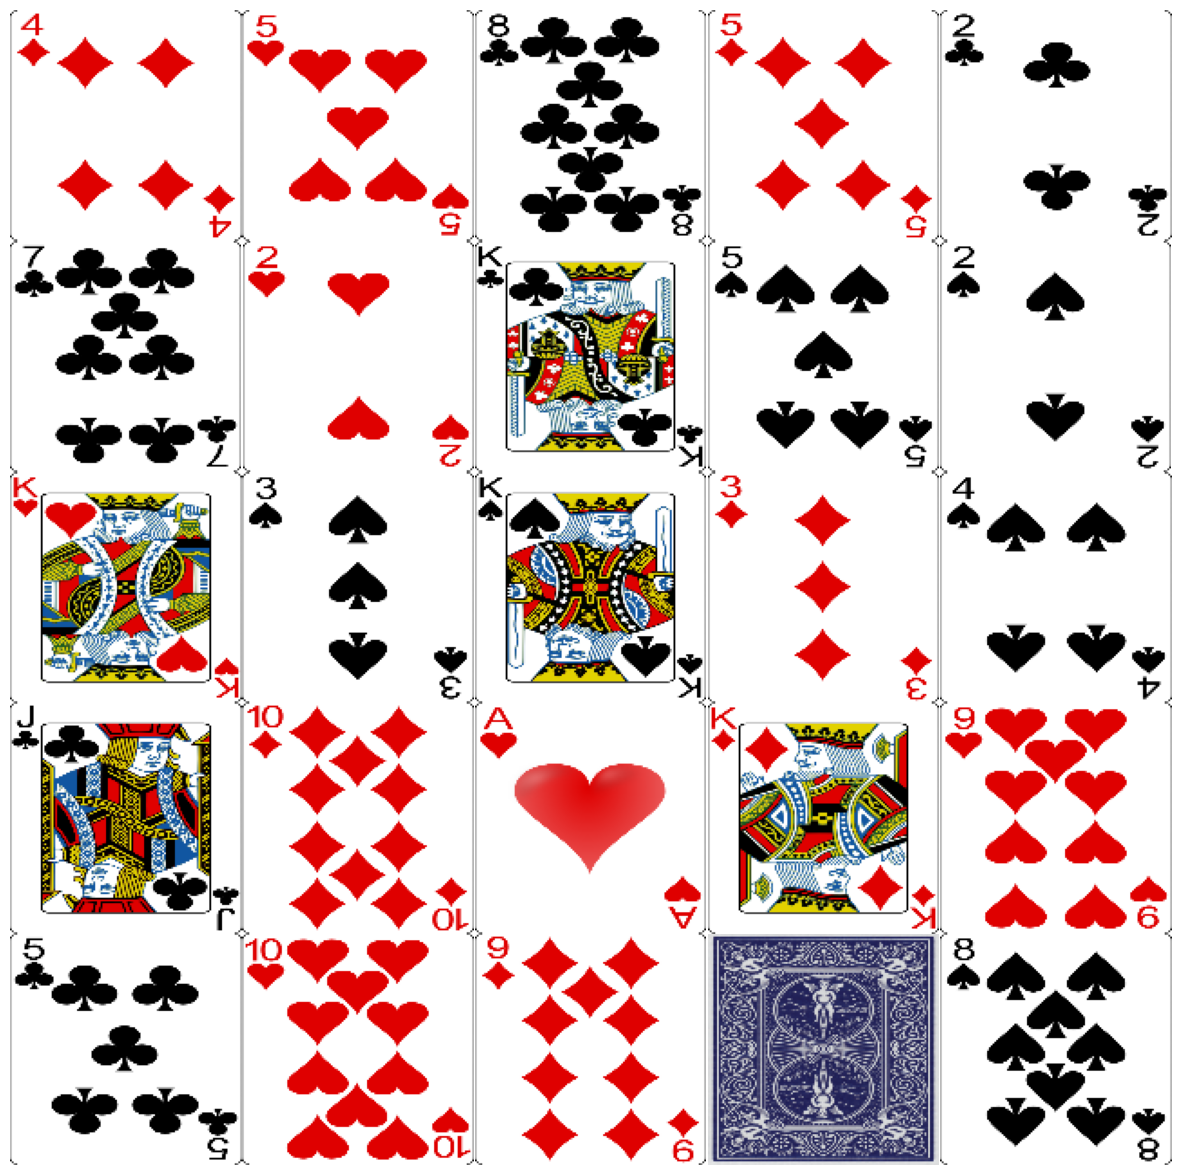

In [20]:
def plot_images(artist, directory, img_size=(128, 128), cols=5, rows=5):
    print(f"Artist: {artist}")    
    # Listing all image files in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('png', 'jpg', 'jpeg'))]    
    # Setting figure size and layout
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)    
    i = 0
    for img_file in image_files[:cols * rows]:
        img = cv2.imread(img_file)
        img = cv2.resize(img, img_size)  # Resize the image
        plt.subplot(rows, cols, i + 1)  # Adjust the subplot grid
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Turn off axis
        i += 1
    plt.show()
plot_images("Black Jack Cards in Grayscale", "../input/black-jack-interactive-card-game/cards", img_size=(128, 128), cols=5, rows=5)

In [21]:
# Check the directory structure
print("Directory structure:")
for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"Found directory: {dirpath}, containing {len(filenames)} files")

Directory structure:
Found directory: /kaggle/input/black-jack-interactive-card-game, containing 0 files
Found directory: /kaggle/input/black-jack-interactive-card-game/cards, containing 53 files


In [22]:
# Image Preprocessing and Data Augmentation
image_size = (128, 128)  # Resize all images
batch_size = 32

In [23]:
data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    validation_split=0.2  # Reserve 20% for validation
)

In [24]:
# Load Training and Validation Data
train_data = data_generator.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 43 images belonging to 1 classes.


In [25]:
val_data = data_generator.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 10 images belonging to 1 classes.


In [26]:

# Class names (card types)
class_names = list(train_data.class_indices.keys())
print(f"Detected card classes: {class_names}")

Detected card classes: ['cards']


In [27]:
# Define the input shape using an Input layer
# For Multi-Class Classification
model = models.Sequential([
    Input(shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Use softmax for multi-class classification
])

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model (ensure labels are one-hot encoded)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 900ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 

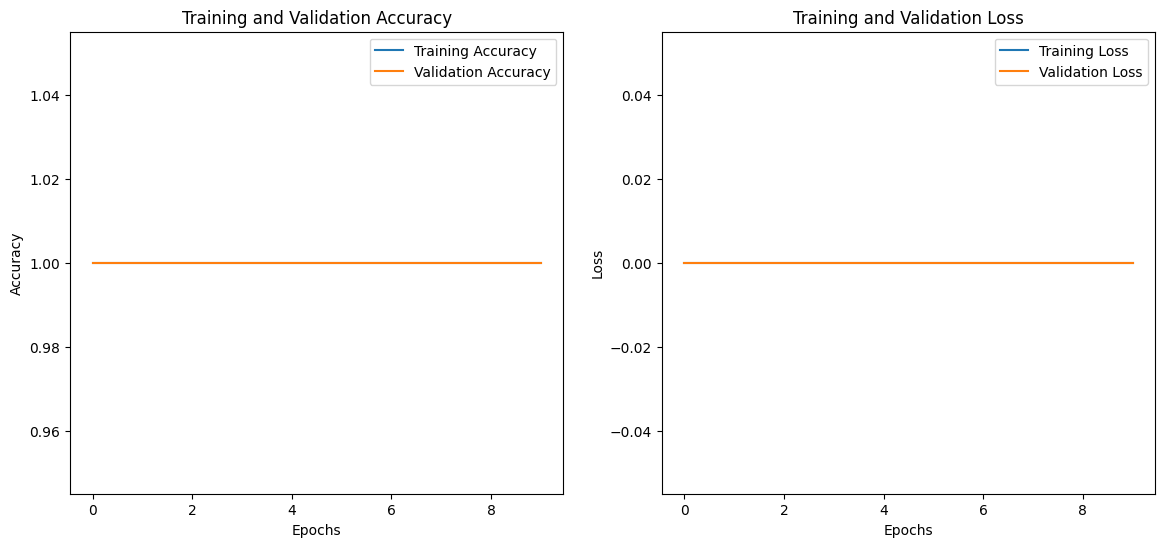

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [32]:
# Blackjack Game with AI Predictions
class BlackjackGame:
    def __init__(self, model, class_names, image_size):
        self.model = model
        self.class_names = class_names
        self.image_size = image_size

    def predict_card(self, image_path):
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)

        predictions = self.model.predict(img_array)
        predicted_class = self.class_names[np.argmax(predictions)]
        confidence = np.max(predictions)
        return predicted_class, confidence

    def display_card(self, image_path, predicted_class, confidence):
        img = Image.open(image_path)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 24)
        text = f"{predicted_class} ({confidence * 100:.1f}%)"
        draw.text((10, 10), text, fill="white", font=font)
        img.show()

    def play_round(self, player_card_path, dealer_card_path):
        print("Player's Turn:")
        player_card, player_confidence = self.predict_card(player_card_path)
        self.display_card(player_card_path, player_card, player_confidence)

        print("\nDealer's Turn:")
        dealer_card, dealer_confidence = self.predict_card(dealer_card_path)
        self.display_card(dealer_card_path, dealer_card, dealer_confidence)

        print(f"\nResult:\nPlayer's Card: {player_card}, Dealer's Card: {dealer_card}")

In [33]:
# Initialize Game
game = BlackjackGame(model, class_names, image_size)

In [34]:
# Define the ImprovedDummyModel class
class ImprovedDummyModel:
    def __init__(self, class_names):
        self.class_names = class_names
        self.model = self.build_model(len(class_names))

    def build_model(self, num_classes):
        # Build a simple model (replace with actual model architecture if needed)
        model = models.Sequential([
            layers.InputLayer(input_shape=(128, 128, 3)),  # Define input shape
            layers.Dense(64, activation='relu'),  # Basic dense layer
            layers.Flatten(),
            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def predict(self, img_array):
        # Simulate predictions for the example
        random_predictions = np.random.rand(1, len(self.class_names))
        random_predictions = random_predictions / np.sum(random_predictions)  # Normalize to make it a probability distribution
        return random_predictions


# Initialize the game
class_names = ["2_of_clubs", "3_of_hearts", "4_of_spades", "5_of_diamonds"]  # List of card classes
model = ImprovedDummyModel(class_names)
image_size = (128, 128)  # Resize to match our model's input size

# Game logic for Blackjack
class BlackjackGame:
    def __init__(self, model, class_names, image_size):
        self.model = model
        self.class_names = class_names
        self.image_size = image_size

    def predict_card(self, image_path):
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)

        predictions = self.model.predict(img_array)
        predicted_class = self.class_names[np.argmax(predictions)]
        confidence = np.max(predictions)
        return predicted_class, confidence

    def annotate_image(self, image_path, predicted_class, confidence, output_size=(150, 150)):
        # Open the image
        img = Image.open(image_path)
        draw = ImageDraw.Draw(img)

        # Use the default PIL font
        font = ImageFont.load_default()

        # Draw the prediction text
        text = f"{predicted_class} ({confidence * 100:.1f}%)"
        draw.rectangle([5, 5, img.width - 5, 30], fill="black")  # Add a background for text
        draw.text((10, 5), text, fill="white", font=font)

        # Resize the image for display
        img = img.resize(output_size)

        # Save the annotated image
        annotated_image_path = f"annotated_{os.path.basename(image_path)}"
        img.save(annotated_image_path)
        return annotated_image_path

    def play_round(self, player_card_path, dealer_card_path):
        print("Player's Turn:")
        player_card, player_confidence = self.predict_card(player_card_path)
        player_image = self.annotate_image(player_card_path, player_card, player_confidence)

        print("\nDealer's Turn:")
        dealer_card, dealer_confidence = self.predict_card(dealer_card_path)
        dealer_image = self.annotate_image(dealer_card_path, dealer_card, dealer_confidence)

        # Display the images side-by-side
        display(HTML(f"""
        <div style="display: flex; align-items: center; justify-content: center;">
            <div style="margin-right: 10px;">
                <img src="{player_image}" alt="Player Card">
                <p>Player's Card</p>
            </div>
            <div>
                <img src="{dealer_image}" alt="Dealer Card">
                <p>Dealer's Card</p>
            </div>
        </div>
        """))

        print(f"\nResult:\nPlayer's Card: {player_card}, Dealer's Card: {dealer_card}")
        print(f"Annotated Player Card Image: {player_image}")
        print(f"Annotated Dealer Card Image: {dealer_image}")


# Initialize the game
class_names = ["2_of_clubs", "3_of_hearts", "4_of_spades", "5_of_diamonds"]  # List of card classes
model = ImprovedDummyModel(class_names)  # Initialize the model
image_size = (128, 128)  # Resize to match our model's input size

game = BlackjackGame(model, class_names, image_size)

# Set valid paths for images (Replace these with the actual paths)
player_card_image = "/kaggle/input/black-jack-interactive-card-game/cards/2_of_clubs.png"
dealer_card_image = "/kaggle/input/black-jack-interactive-card-game/cards/3_of_hearts.png"

if os.path.exists(player_card_image) and os.path.exists(dealer_card_image):
    print("Starting Blackjack game with valid card images...")
    game.play_round(player_card_image, dealer_card_image)

Starting Blackjack game with valid card images...
Player's Turn:

Dealer's Turn:



Result:
Player's Card: 3_of_hearts, Dealer's Card: 4_of_spades
Annotated Player Card Image: annotated_2_of_clubs.png
Annotated Dealer Card Image: annotated_3_of_hearts.png


# The player's and dealer's cards are predicted, and random probabilities are generating results for each round.

# GOOD LUCK!!